# Introduction 
This notebook demonstrates the Metropolis-Hastings Markov Chain Monte Carlo (MH-MCMC) process applied to partial orders.

a) Starting with a given partial order, we sample corresponding total orders.

b) Using the sampled total orders from part (a), we infer the original partial order.

For this analysis, we utilize several utility functions located in utils/po_fun.py and utils/po_fun_plot.py. Additionally, the MH-MCMC implementation is provided in the po_mcmc.py source code file.


In [1]:
import sys
# Add the path to the src directory to access utility modules and po_hm_mcmc.py
sys.path.append('../src')  # Adjust the path if your directory structure is different
 # Adjust this path based on your directory structure
# Import necessary libraries
import numpy as np
import networkx as nx
import random
import itertools
import matplotlib.pyplot as plt
import pygraphviz as pgv
from typing import List, Dict, Any
import seaborn as sns

# Import utility classes from their respective modules
from utils.po_fun import GenerationUtils,BasicUtils,StatisticalUtils
from utils.po_fun_plot import PO_plot
from po_hm_mcmc import mcmc_partial_order

## a) Sampling Total Orders from a Given Partial Order

### Generating a Partial Order
We generate a partial order using the `generate_random_PO` function and provide the basic description of the PO.
#### Comments on Generating Samples from a Given Partial Order:

- **Setting the Parameter `N`:**
  - The value of `N` should be chosen thoughtfully to ensure the quality of the MCMC sampling.
  - **Example:** When `N` is set to 5, we generate 50 observations for the MCMC. Choosing a different value for `N` may result in missing relationships between nodes, potentially compromising the integrity of the partial order.
  

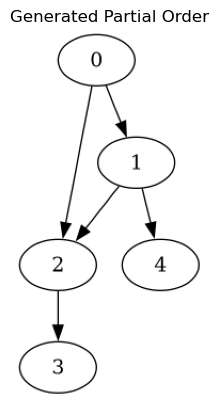

The targeted partial order h is : [[0 1 1 0 0]
 [0 0 1 0 1]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

--- Partial Order Description ---
Number of Nodes: 5
Number of Relationships: 5
Number of Alone Nodes: 0
Alone Nodes: []
Maximum In-Degree: 2
Maximum Out-Degree: 2
Maximum Relationships per Node: 2
Number of Linear Extensions: 3
Depth of Partial Order: 3
---------------------------------


In [2]:
n = 5 # We want 4 objects 
N= 50 # We want 6 observations
random_PO = GenerationUtils.generate_random_PO(n)
h = nx.to_numpy_array(random_PO, dtype=int)
h_true=h.copy()
PO_plot.visualize_partial_order(h, title='Generated Partial Order')
print(f"The targeted partial order h is : {h}")

# Describe the partial orders 
StatisticalUtils.description_partial_order(h)

### Generating Total Orders from the Partial Order (PO)

First, we need to obtain subsets from different accessors:

- **Given a subset**, we sample a total order.
- **In the end**, we provide statistics of the total orders.



Top 15 Most Frequent Total Orders:
          Total Order  Frequency
0   0 > 1 > 4 > 2 > 3          7
1           1 > 2 > 3          5
2               1 > 2          3
3               2 > 3          3
4   0 > 1 > 2 > 4 > 3          3
5   0 > 1 > 2 > 3 > 4          3
6               0 > 4          2
7               1 > 4          2
8       0 > 1 > 2 > 3          2
9       1 > 4 > 2 > 3          2
10              4 > 3          1
11              2 > 4          1
12      0 > 1 > 4 > 3          1
13              3 > 4          1
14      0 > 1 > 2 > 4          1


/home/doli/Desktop/research/coding/BayesianPartialOrders/notebooks/../src/utils/po_fun_plot.py:280: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


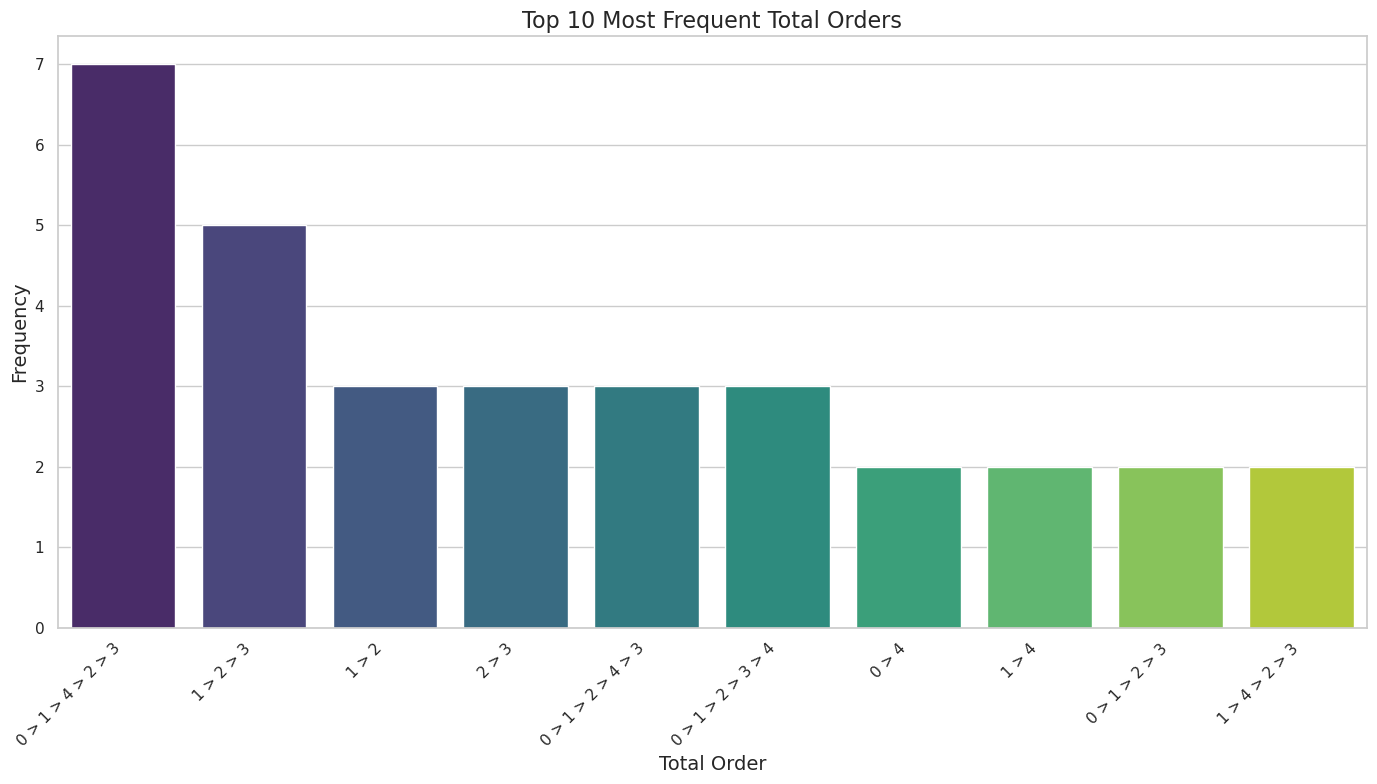

In [3]:
subsets = GenerationUtils.generate_subsets(N, n)
total_orders = []
for subset in subsets:
    yi = GenerationUtils.sample_total_order(h, subset)
    total_orders.append(yi)

PO_plot.visualize_total_orders(total_orders, top_print=15, top_plot=10)

## b) MCMC Simulation 

We want to performa the MCMC simulation to infer the h 
- h is caclualted from taking the mean of the h_trace
- we also curious abou the distribution for the h_trace 
- We will check the simulated h and the defined-h and they should be the same 

In [4]:
# Perform MCMC
num_iterations= 10000  #Number of MCMC iterations
rho = 0.8 # correlation between different covariates 
Sigma=2   # Step size for Z
K = 4  # Dimensionality of Z
mcmc_results = mcmc_partial_order(
    observed_orders=total_orders,
    choice_sets=subsets,
    num_iterations=num_iterations,
    Sigma=Sigma,
    K=K,
    rho=rho
)
h_final=np.mean(mcmc_results['h_trace'],axis=0)

threshold=0.5
index_to_item = mcmc_results['index_to_item']
iterations = list(range(1, num_iterations + 1))

h_final_inferred=(h_final>=threshold).astype(int)


Initial partial order h_Z:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Iteration 1000/10000 - Cumulative Acceptance Rate: 29.90%
Iteration 2000/10000 - Cumulative Acceptance Rate: 30.35%
Iteration 3000/10000 - Cumulative Acceptance Rate: 28.77%
Iteration 4000/10000 - Cumulative Acceptance Rate: 29.00%
Iteration 5000/10000 - Cumulative Acceptance Rate: 28.88%
Iteration 6000/10000 - Cumulative Acceptance Rate: 29.32%
Iteration 7000/10000 - Cumulative Acceptance Rate: 29.33%
Iteration 8000/10000 - Cumulative Acceptance Rate: 29.28%
Iteration 9000/10000 - Cumulative Acceptance Rate: 29.21%
Iteration 10000/10000 - Cumulative Acceptance Rate: 29.31%

Overall Acceptance Rate after 10000 iterations: 29.31%


### Visulise for the h_trace and Z_Trace from the MCMC 

Partial Order 1:
[[0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 7488

Partial Order 2:
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 988

Partial Order 3:
[[0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 912

Partial Order 4:
[[0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 549

Partial Order 5:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 40

Partial Order 6:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Count: 23

Total number of samples in h_trace: 10000



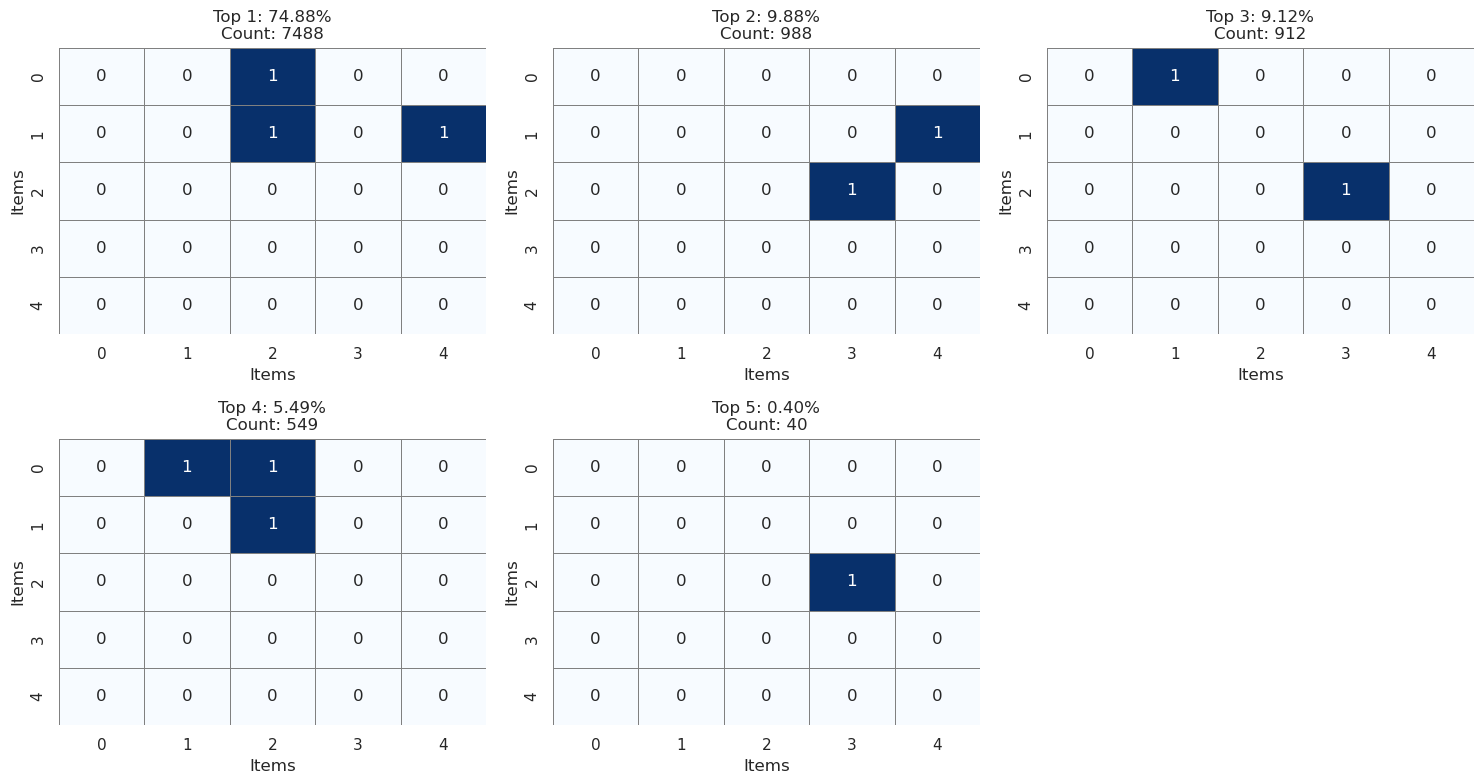

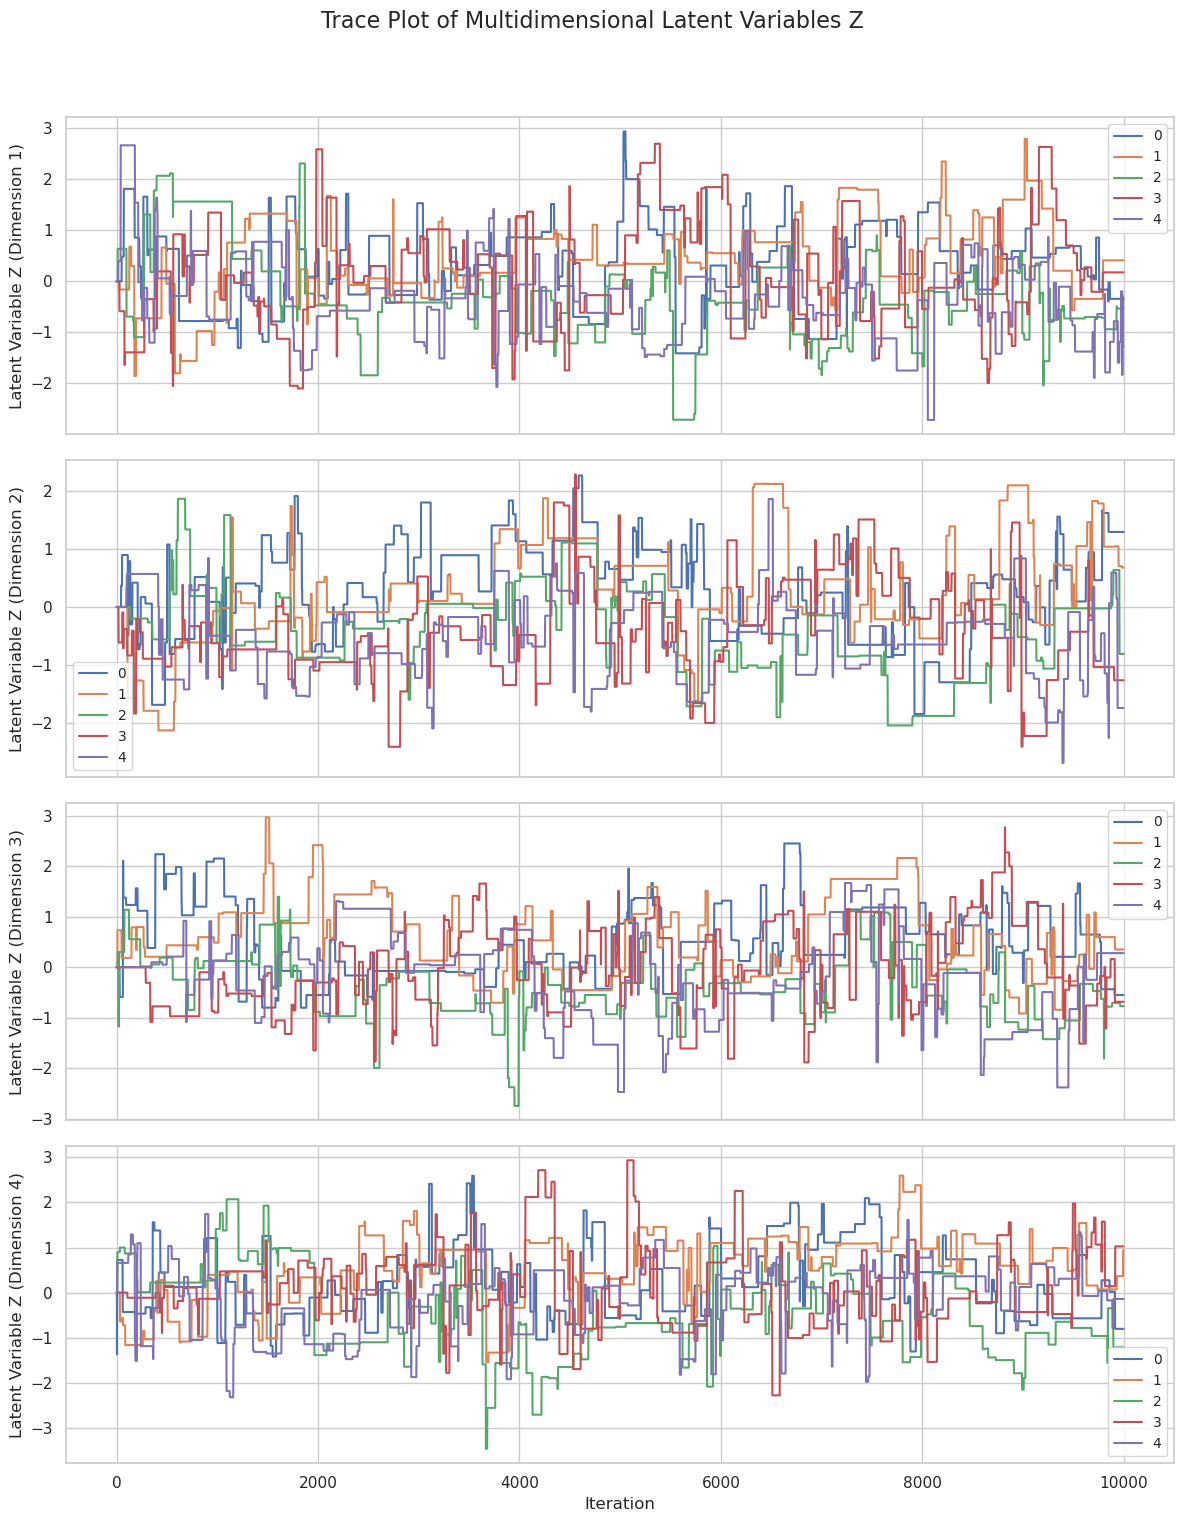

[[0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [5]:
# Example usage
sorted_unique_orders = StatisticalUtils.count_unique_partial_orders(mcmc_results['h_trace'])

# Print the sorted partial orders with their counts
for idx, (order, count) in enumerate(sorted_unique_orders, 1):
    print(f"Partial Order {idx}:\n{order}\nCount: {count}\n")

total_samples = sum(count for _, count in sorted_unique_orders)
print(f"Total number of samples in h_trace: {total_samples}\n")
top_n = 5
top_partial_orders = sorted_unique_orders[:top_n]
top_percentages = [(order, count, (count / total_samples) * 100) for order, count in top_partial_orders]

items = sorted(set(itertools.chain.from_iterable(total_orders)))
n = len(items)
item_labels = items  # ['A', 'B', 'C']
# Plot the top 5 partial orders
PO_plot.plot_top_partial_orders(top_percentages, top_n=top_n, item_labels=item_labels)

PO_plot.plot_Z_trace(mcmc_results['samples_Z'],index_to_item)
print(h_final_inferred)

We see that the likelihood plot is converging after about 2000 iterations.

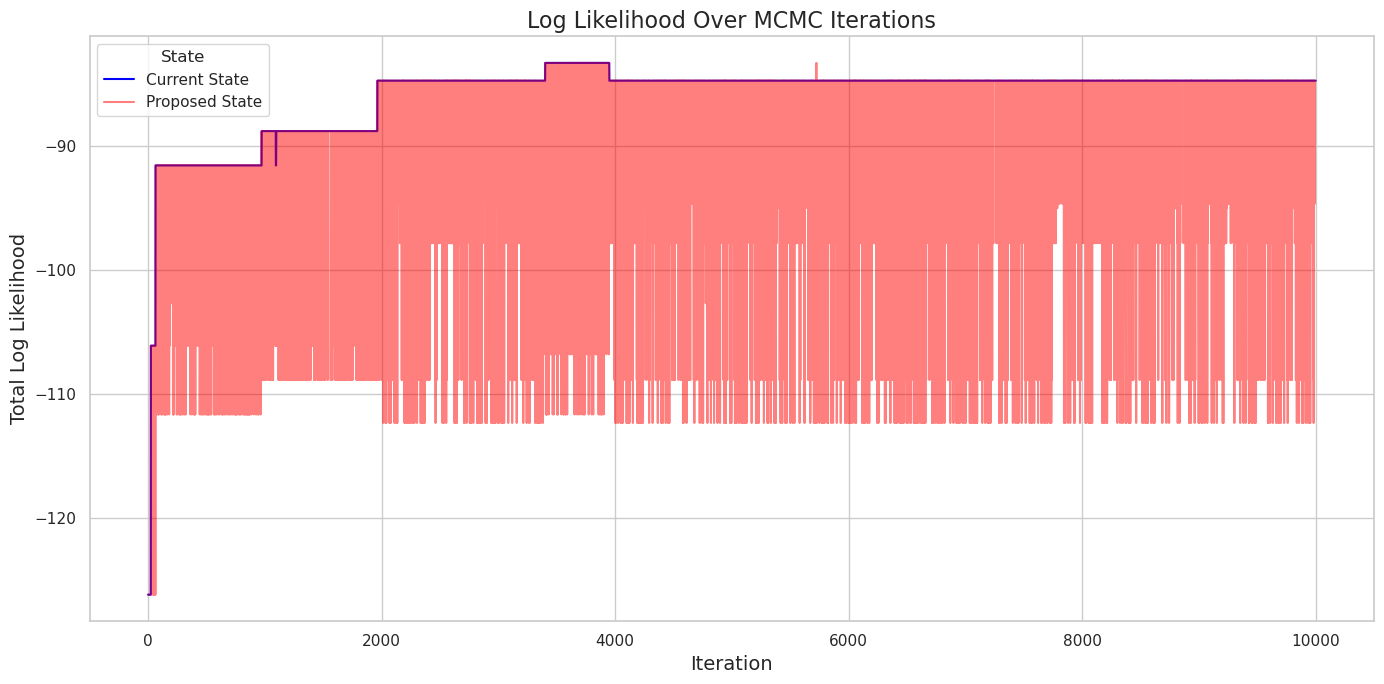

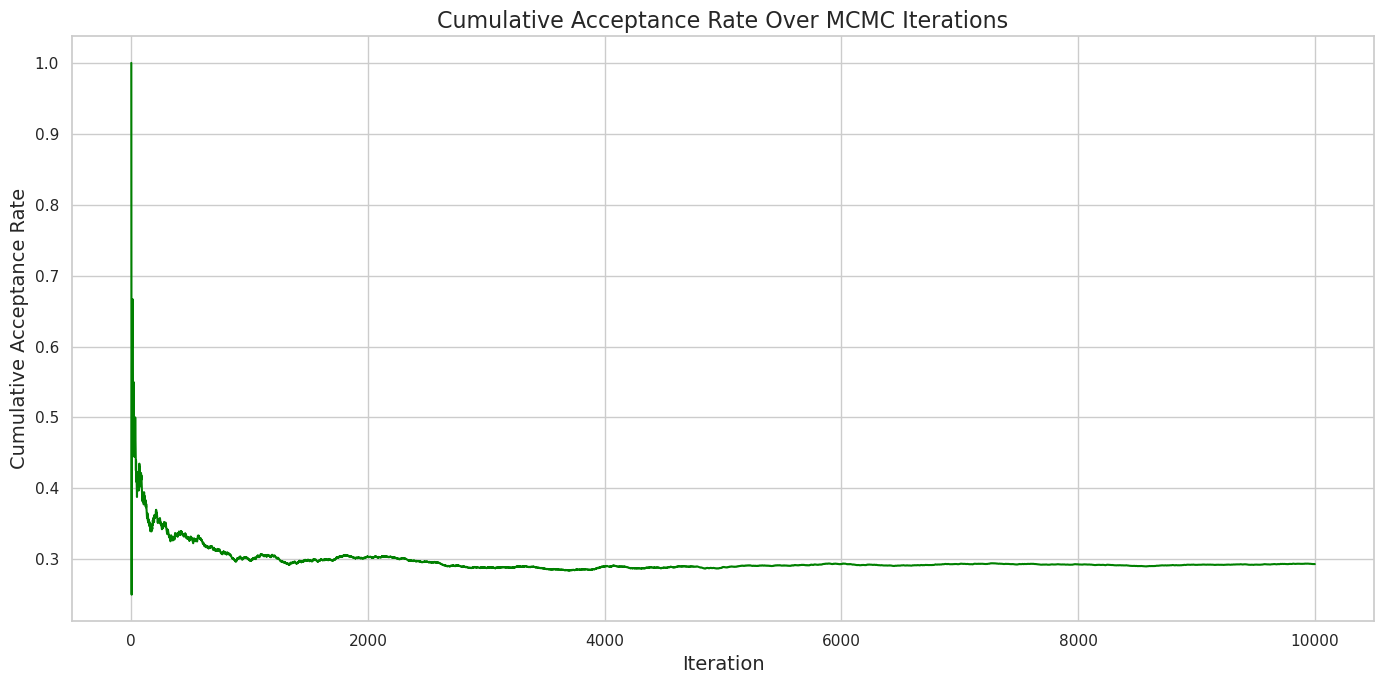

In [6]:

PO_plot.plot_log_likelihood(mcmc_results, title='Log Likelihood Over MCMC Iterations')
PO_plot.plot_acceptance_rate(mcmc_results['acceptance_rates'], num_iterations)

### Inferred h comparison 
In the end, we want to compare the simulated h and the true h, especially the missing relationship between items.

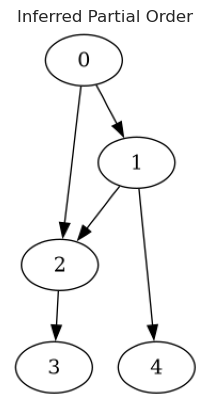

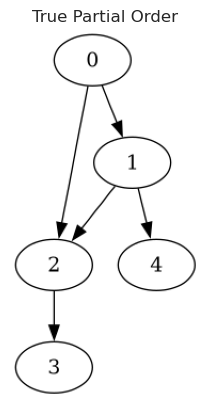


No missing relationships. The inferred partial order matches the true partial order.


In [7]:

def compute_missing_relationships(h_true: np.ndarray, h_final: np.ndarray, index_to_item: Dict[int, int]) -> List[tuple]:
    """
    Compute the missing relationships between the true partial order and the inferred partial order.
    
    Parameters:
    - h_true (np.ndarray): Adjacency matrix of the true partial order.
    - h_final (np.ndarray): Adjacency matrix of the inferred partial order.
    - index_to_item (Dict[int, int]): Mapping from index to item.
    
    Returns:
    - List[tuple]: List of tuples representing the missing relationships (i, j).
    """
    missing = []
    n = h_true.shape[0]
    for i in range(n):
        for j in range(n):
            if h_true[i, j] == 1 and h_final[i, j] == 0:
                missing.append( (index_to_item[i], index_to_item[j]) )
    return missing


# Plot Inferred Partial Order
PO_plot.visualize_partial_order(
    final_h=h_final,
    title='Inferred Partial Order',
)

# Plot True Partial Order and Inferred Partial Order
PO_plot.visualize_partial_order(
    final_h=h_true,
    title='True Partial Order',
)


missing_relationships = compute_missing_relationships(h_true, h_final, index_to_item)

if missing_relationships:
    print("\nMissing Relationships (edges present in true PO but absent in inferred PO):")
    for i, j in missing_relationships:
        print(f"{i} < {j}")
else:
    print("\nNo missing relationships. The inferred partial order matches the true partial order.")
